# Behavioral cloning project

In this project we will use deep neural networks and convolutional neural networks to clone driving behavior. With the help of a driving simulator, we will train, validate and test a model using Keras. The model will output a steering angle to an autonomous vehicle that will drive on a simulator track.The CNN thus clones the human driving behavior.


## Imports

In [24]:
import pandas as pd
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import random
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from random import uniform

## Data Collection

The simulator recorded 9-10 datapoints per second. Each datapoint comprised 7 attributes:

##### Images
1. Image taken from the center camera on the car 
2. Image taken from the left camera on the car
3. Image taken from the right camera on the car


##### CSV file

4. Throttle
5. Speed
6. Brake
7. Steering angle (float number between from -1.0 to 1.0)


In order to get more data and to acheive a better modeling , we have been recording 2-3 laps on the tracks and did the same driving on the opposite way.After trial an error we've also added few recovery scenario to teach the car how to get back to the center of the road. Lets load theses datas :

#### Load the CSVs

In [25]:
# #load track 1 data
t1_df = pd.read_csv('C:/Users/Fly_Boy/Desktop/Udacity/windows_sim/track1_good_way/driving_log.csv')
             
# #Load reverse track 1 data
rt1_df = pd.read_csv('C:/Users/Fly_Boy/Desktop/Udacity/windows_sim/track1_wrong_way/driving_log.csv')

# #Back to track training data
btt1_df = pd.read_csv('C:/Users/Fly_Boy/Desktop/Udacity/windows_sim/track1_back_to_track_training/driving_log.csv')

#turn right
tr_df = pd.read_csv('C:/Users/Fly_Boy/Desktop/Udacity/windows_sim/turn_right/driving_log.csv')

#turn right last
trl_df = pd.read_csv('C:/Users/Fly_Boy/Desktop/Udacity/windows_sim/turn_right_last/driving_log.csv')

#load Udacity data
dft1_df = pd.read_csv('C:/Users/Fly_Boy/Desktop/Udacity/windows_sim/data/driving_log.csv')

#Hard dirt section
hard_df = pd.read_csv('C:/Users/Fly_Boy/Desktop/Udacity/windows_sim/dirt/driving_log.csv')

#track2 Data
t2_df = pd.read_csv('C:/Users/Fly_Boy/Desktop/Udacity/windows_sim/track2/driving_log.csv')

#track2 Data
t2_r_df = pd.read_csv('C:/Users/Fly_Boy/Desktop/Udacity/windows_sim/track2/driving_log.csv')


#set column names
t1_df.columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle' ,'Break' , 'Speed']
rt1_df.columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle' ,'Break' , 'Speed']
btt1_df.columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle' ,'Break' , 'Speed']
tr_df.columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle' ,'Break' , 'Speed']
dft1_df.columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle' ,'Break' , 'Speed']
hard_df.columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle' ,'Break' , 'Speed']
t2_df.columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle' ,'Break' , 'Speed']
t2_r_df.columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle' ,'Break' , 'Speed']
trl_df.columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle' ,'Break' , 'Speed']


In [26]:
#select the training data we will use (mutliple scenario have been tried)
frames = [t1_df,rt1_df,dft1_df,hard_df,trl_df]
df = pd.concat(frames)
df.shape

(23924, 7)

#### Load the simulator images

In [27]:
center_img_path = df[['Center Image']]
left_img_path = df[['Left Image']]
right_img_path = df[['Right Image']]

In [28]:
#lets do a little sanity check :
assert len(center_img_path) == len(left_img_path)
assert len(center_img_path) == len(right_img_path)
assert len(center_img_path) == len(df)

## Data exploration

We have so far a dataset of shape (23924, 7) where we can see that each line contains our 7 Data Points
Each camera image is of shape: (160, 320, 3) and are as follow : 


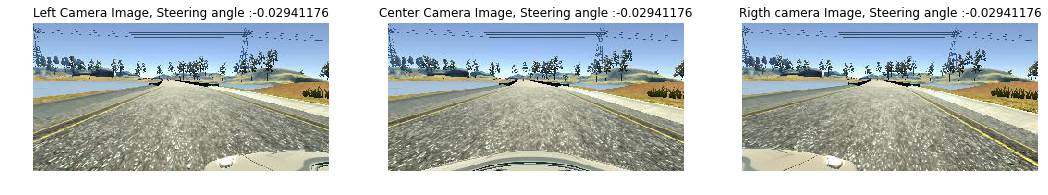

In [29]:
print("We have so far a dataset of shape", df.shape ,"where we can see that each line contains our 7 Data Points")

index = random.randint(0, len(df))

#Lets look at some images 
fig = plt.figure(figsize=(18, 10))

plt.subplot(1,3,1)
image = plt.imread(left_img_path.iloc[index][0].replace('\\','/'))
plt.imshow(image)
plt.title('Left Camera Image, Steering angle :' + str(df.iloc[index][3]))
plt.axis('off')

plt.subplot(1,3,2)
image = plt.imread(center_img_path.iloc[index][0].replace('\\','/'))
plt.imshow(image)
plt.title('Center Camera Image, Steering angle :' +str(df.iloc[index][3]))
plt.axis('off')

plt.subplot(1,3,3)
image = plt.imread(right_img_path.iloc[index][0].replace('\\','/'))
plt.imshow(image)
plt.title('Rigth camera Image, Steering angle :' + str(df.iloc[index][3]))
plt.axis('off')

print("Each camera image is of shape:",image.shape ,"and are as follow : ")

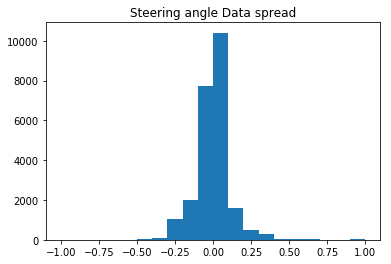

(23924, 7)

In [30]:
num_bins = 20
plt.hist(df['Steering Angle'].values, bins=num_bins , range=(-1 ,1)) 
plt.title("Steering angle Data spread")
plt.show()
# hist, bins = np.histogram(df['Steering Angle'].values, num_bins)
# hist
df.shape

We can see that the steering angle distribution cover all kind of range between [-1.0 and 1.0] we can notice a strong concentration of data surrounding the neutral streering position. This wil cause our model to mostly learn how to drive straighforward,so lets rebalance our data. Hopefully the recovering data will also help recover from odd position.

### Rebalancing the Data

In [31]:
def rebalance_zeros_df_angles(df,keep_nb):
    zeros_df=df[df['Steering Angle'] == 0]
    non_zeros_df=df[df['Steering Angle'] != 0]
    zeros_df = shuffle(zeros_df)
    new_df = pd.concat([non_zeros_df, zeros_df[0:keep_nb]])
    return new_df

def rebalance_df_angles(df,target):

    angles = list(df['Steering Angle'])
    hist, bins = np.histogram(angles, num_bins)
    bins_count = np.zeros(num_bins)
    remove_list = []
    for i in range(len(angles)):
            for j in range(num_bins):
                 if ((angles[i] > bins[j]) and (angles[i] <= bins[j+1])):
                        bins_count[j] = bins_count[j] + 1
                        if int(bins_count[j]) > target:
                            remove_list.append(i)
    return df.drop(remove_list)

In [32]:
df=shuffle(df)
df = rebalance_zeros_df_angles(df,400)
df= rebalance_df_angles(df,400)
df.shape

(6762, 7)

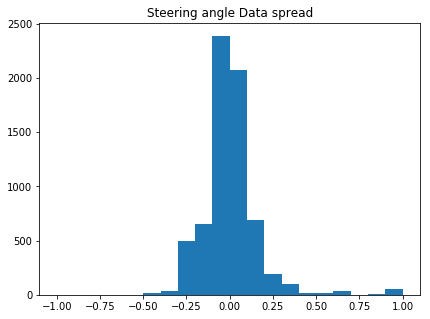

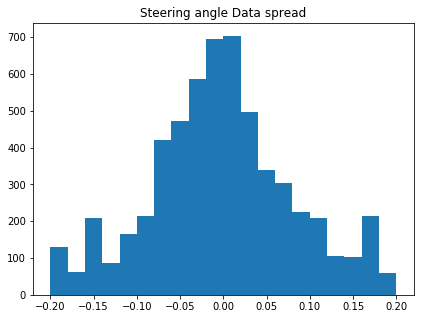

In [33]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(df['Steering Angle'].values, bins=num_bins , range=(-1 ,1)) 
plt.title("Steering angle Data spread")
plt.show()
fig = plt.figure(figsize=(15, 5))
plt.subplot(1,2,2)
plt.hist(df['Steering Angle'].values, bins=num_bins , range=(-.2 ,.2)) 
plt.title("Steering angle Data spread")
plt.show()

Our data sounds like more balanced , hopefully this help our model turning when needed and not only teaches him going straighforward, we will also use data augmentation to rebalance the training set for left and right steering.

## Data Augmentation

#### Initial state:
In order to improve our model performance we have aquired data driving : 

1. several laps in the right way
2. several slaps in the opposite track way.
3. We have also recorded few recovering scenarios where we put the car in bad situation on purpose and record how to recover from it. This is where we get extremum steering angle data. 

#### Lets get even more data : 

4. For us to get even more driving data and not having to spend a lot of time driving the car on the simulator, we will not only use the center camera but as well as the right and left camera, this should triple our Training set ( for this part we will slightly modify angle value for the left and right camera

5. In addition to this, we will apply a vertical mirror filter on the images and chnage the steering angle. This should also double our available dataset.

6. Lets also apply random contrast/brightness and image scaling



In [34]:
def read_img(img_path):
    img = cv2.imread(img_path) #BGR image
    return  cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #RGB

#### Vertically flipping the image

In [35]:
def flip_img(img):
    horizontal_img = cv2.flip( img, 1 )
    return horizontal_img

(-0.5, 319.5, 159.5, -0.5)

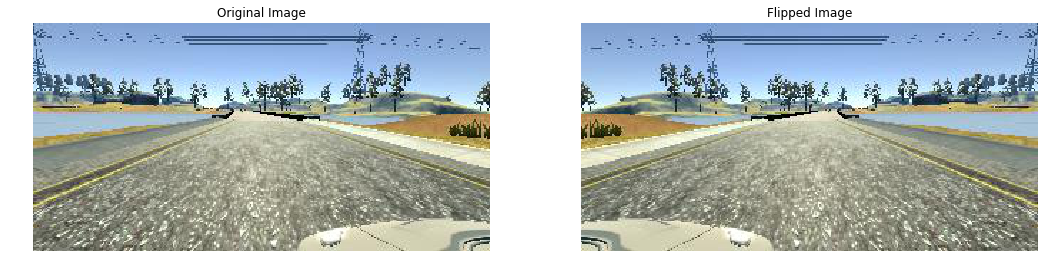

In [36]:
#Here is what our image flip augmentation look like 
fig = plt.figure(figsize=(18, 10))

plt.subplot(1,2,1)
image = read_img(left_img_path.iloc[index][0].replace('\\','/'))
plt.imshow(image)
plt.title('Original Image' + str())
plt.axis('off')

plt.subplot(1,2,2)
image =flip_img(image)
plt.imshow(image)
plt.title('Flipped Image')
plt.axis('off')

#### Random contrast/brightness

In [37]:
#Lets allow random contrast/brightness changes

def random_contrast(img):
    
    contrast = random.uniform(1,2)
    brightness = random.randint(0,1)

    return cv2.add(cv2.multiply(img, np.array([contrast])), brightness)   

(-0.5, 319.5, 159.5, -0.5)

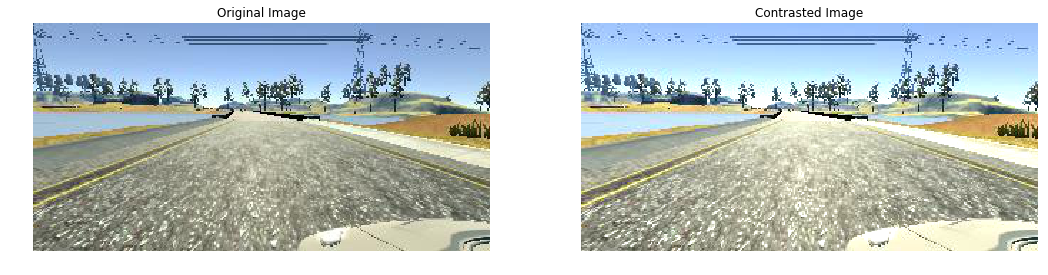

In [38]:
#Here is what our image contrast.brightness augmentation look like 
fig = plt.figure(figsize=(18, 10))

plt.subplot(1,2,1)
image = read_img(left_img_path.iloc[index][0].replace('\\','/'))
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
image =random_contrast(image)
plt.imshow(image)
plt.title('Contrasted Image')
plt.axis('off')

#### Random scaling

In [39]:
#Lets allow random increased scaling changes up to 2 px

def random_scaling(img):  
    cols,rows,_ = img.shape
    px = np.random.randint(0,5)
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(img,M,(rows,cols))
    return dst

(-0.5, 319.5, 159.5, -0.5)

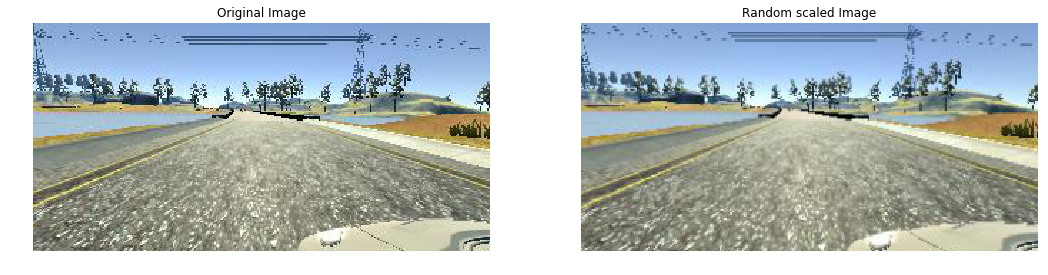

In [40]:
#Here is what our image scaling augmentation look like 
fig = plt.figure(figsize=(18, 10))

plt.subplot(1,2,1)
image = read_img(left_img_path.iloc[index][0].replace('\\','/'))
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
image =random_scaling(image)
plt.imshow(image)
plt.title('Random scaled Image')
plt.axis('off')

Awesome we have increased the dataset size, lets now preprocess theses data.

## Pre Processing

#### Crop the Data
As our model can be confused by the low part where we see the car hood , we will crop this part. In addition to this the top part of the image contains only landscape and sky , which doesn't represent a great deal of usefull information for our model. We will then have our model focussing on the road by croping 65px from top and 25px from the bottom of our original image of size (160,320, 3). After cropping the image we will also resize the image to a (60,90,3) size for model performance. additionally we will blur the image slightly.

In [41]:
def crop_and_resize(img):
    y, x, z = img.shape
    crop_img = img[65:y-25, 0:x]
    resized_img = cv2.resize(crop_img, (90,60))
    return resized_img

In [42]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

(-0.5, 89.5, 59.5, -0.5)

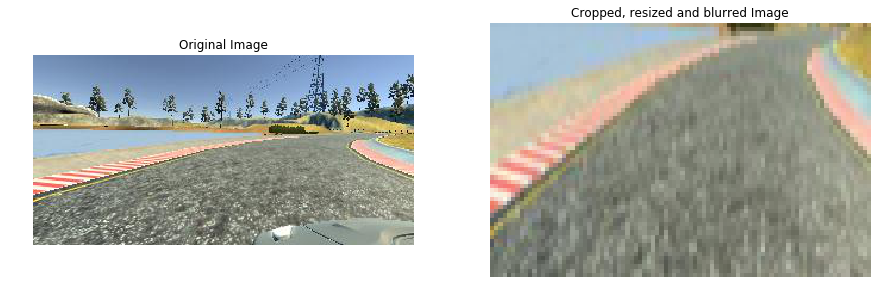

In [43]:
index = random.randint(0, len(df))

fig = plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
image = plt.imread(left_img_path.iloc[index][0].replace('\\','/'))
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(crop_and_resize(gaussian_blur(image,3)))
plt.title('Cropped, resized and blurred Image')
plt.axis('off')

#### Normalize the Data

We will have the normalization occuring in the model as converting int array to float array quite severly change the memory needs.

#### Shuffle our data

Will happen within our generator

# Lets define our generator

As the dataset size is important , we won't be able to load it fully into our memory , for this reason we will use a generator that would enable to deal a process image after image as they are needed.

In this generator we will

1. Use the three different camera images
2. Augment the data by fliping it verticaly (and invert the steering angle)
3. Augment the data by generating a radom contrasted/ scaled version of it

our drive.py code as been modified to read image as YUV (the prediclected image mode for our model), we will also train our model using YUV for consistency by defining a process_image function that will process all of our images

In [21]:
def process_image(path):
    rgb_img = read_img(path)
    crop_b_img = crop_and_resize(gaussian_blur(rgb_img,3))
    img = cv2.cvtColor(crop_b_img, cv2.COLOR_RGB2YUV)
    return img

## Generator pipeline

In [22]:
BATCH_SIZE = 64
def generator(df, batch_size=BATCH_SIZE):
    
    num_samples = len(df)
   
    #infinite looping
    while True:
        
        for offset in range(0, num_samples, batch_size):
            
            images = []
            angles = []
        
                      
            batch_samples = df[offset:offset+batch_size]
            center_img_path = batch_samples[['Center Image']]
            left_img_path = batch_samples[['Left Image']]
            right_img_path = batch_samples[['Right Image']]
            
            
            for i in range(len(batch_samples)):
                                
                '''Center image '''
                #set angle correction
                correction = 0
                
                #get angle
                angle = float(df.iloc[i][3])

                #get path
                center_path = center_img_path.iloc[i][0].replace('\\','/')
                center_img = process_image(center_path)

                #load the camera image in our dataset
                images.append(center_img)
                angles.append(angle)
                    
                # generate a flipped image and load it in our dataset
                images.append(flip_img(center_img))
                angles.append(-(angle + correction))

                #Generate augmented image and load it in our dataset
                images.append(random_contrast(center_img))
                angles.append(angle + correction)

                '''Left image '''
                correction = 0.2

                #get path
                left_path = left_img_path.iloc[i][0].replace('\\','/')
                left_img =  process_image(left_path)

                #load the camera image in our dataset
                images.append(left_img)
                angles.append(angle + correction)

                # generate a flipped image and load it in our dataset
                images.append(flip_img(left_img))
                angles.append(-(angle + correction))

#                 #Generate augmented image and load it in our dataset
#                 images.append(random_contrast(left_img))
#                 angles.append(float(df.iloc[i][3] + correction))


                '''Righ image '''

                #set angle correction
                correction = -0.2

                #get path
                right_path = right_img_path.iloc[i][0].replace('\\','/')
                right_img =  process_image(right_path)

                #load the camera image in our dataseta
                images.append(right_img)
                angles.append(angle + correction)

                # generate a flipped image and load it in our dataset
                images.append(flip_img(right_img))
                angles.append(-(angle + correction))

#                 #Generate augmented image and load it in our dataset
#                 images.append(random_contrast(right_img))
#                 angles.append(angle + correction)


                images, angles = shuffle(images, angles)
                    
                right_img = None
                left_img = None
                center_img = None
                
            #Output images and angles at the end of each batch    
            yield np.array(images), np.array(angles)
            
            images = None
            angles = None

In [23]:
from sklearn.model_selection import train_test_split

#split our dataset into a train dataset and a validation dataset
train_samples, validation_samples = train_test_split(df, test_size=0.2)

# Create our generator function
train_generator = generator(train_samples, BATCH_SIZE)
validation_generator = generator(validation_samples, BATCH_SIZE)

## Creating our model

In [24]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam , RMSprop

C:\Users\Fly_Boy\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Define the NVIDA model (modified for our input/output need)

In [25]:
nvidia = Sequential()

#normalize our data
nvidia.add(Lambda(lambda x: x/255. - 0.5, input_shape=(60, 90, 3)))

#convolutional layers
nvidia.add(Conv2D(24, (3, 3), activation="relu", strides=(2, 2)))
nvidia.add(Conv2D(36, (3, 3), activation="relu", strides=(2, 2)))
nvidia.add(Conv2D(48, (3, 3), activation="relu"))
nvidia.add(Conv2D(64, (3, 3), activation="relu"))
nvidia.add(Conv2D(64, (3, 3), activation="relu"))
  
#Added dropout for regularization
nvidia.add(Dropout(0.5))

#flatten and end up with fully connected layer endding up with one output
nvidia.add(Flatten())
nvidia.add(Dense(100))
nvidia.add(Dense(50))
nvidia.add(Dense(10))
nvidia.add(Dense(1))

## Train the model

In [26]:
%%time
# Hyperparameters
EPOCHS = 3
STEPS_PER_EPOCH = (len(train_samples))/BATCH_SIZE
VALIDATION_STEPS = (len(validation_samples))/BATCH_SIZE

# Training

model_optimiser = Adam(lr = 1e-4)

nvidia.compile(loss='mse', optimizer=model_optimiser)
Data_log = nvidia.fit_generator(train_generator, steps_per_epoch = STEPS_PER_EPOCH,
                     validation_data=validation_generator, 
                     validation_steps=VALIDATION_STEPS, epochs=EPOCHS)
nvidia.save('model.h5')

Epoch 1/3
85/84 [==============================] - ETA: 5:12 - loss: 0.053 - ETA: 2:37 - loss: 0.053 - ETA: 1:45 - loss: 0.053 - ETA: 1:19 - loss: 0.053 - ETA: 1:04 - loss: 0.052 - ETA: 53s - loss: 0.052 - ETA: 46s - loss: 0.05 - ETA: 40s - loss: 0.05 - ETA: 36s - loss: 0.05 - ETA: 33s - loss: 0.05 - ETA: 32s - loss: 0.05 - ETA: 31s - loss: 0.05 - ETA: 30s - loss: 0.05 - ETA: 29s - loss: 0.05 - ETA: 29s - loss: 0.05 - ETA: 28s - loss: 0.05 - ETA: 28s - loss: 0.05 - ETA: 27s - loss: 0.05 - ETA: 27s - loss: 0.05 - ETA: 26s - loss: 0.05 - ETA: 25s - loss: 0.05 - ETA: 25s - loss: 0.05 - ETA: 25s - loss: 0.05 - ETA: 24s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 23s - loss: 0.05 - ETA: 22s - loss: 0.04 - ETA: 22s - loss: 0.04 - ETA: 21s - loss: 0.04 - ETA: 21s - loss: 0.04 - ETA: 20s - loss: 0.04 - ETA: 20s - loss: 0.04 - ETA: 20s - loss: 0.04 - ETA: 19s - loss: 0.04 - ETA: 19s - loss: 0.04 - ETA: 18s - loss: 0.04 - ETA: 18s - loss: 0.04 - ETA: 18s - loss: 0.04 - ET

## Analyse the model results

dict_keys(['val_loss', 'loss'])


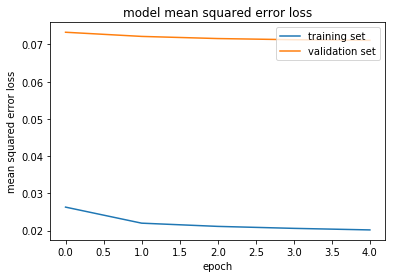

In [32]:
### print the keys contained in the history object
print(Data_log.history.keys())

### plot the training and validation loss for each epoch
plt.plot(Data_log.history['loss'])
plt.plot(Data_log.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

So far the model seems to perform well on the validation set but it does'nt mean that the car will perform well on the track , the solution : lets try it on the simulator !